In [3]:
import os
import os
import pandas as pd
import numpy as np
from nilearn.image import concat_imgs
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix

# define paths
root_dir = '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2'
fmriprep_dir = os.path.join(root_dir, 'derivatives', 'fmriprep23')
output_dir   = os.path.join(root_dir, 'derivatives', 'mvpa_01_musicnoise')

# define subjects
subjectList = ['sub-01','sub-02','sub-03','sub-04','sub-05','sub-06','sub-07','sub-08','sub-09','sub-10',
               'sub-11','sub-12','sub-13','sub-14','sub-15','sub-16','sub-17']
runList     = ['1','2','3','4']

# create combinations of subjects and runs
combinations = [(subj, run) for subj in subjectList for run in runList]



In [2]:
combinations

[('sub-01', '1'),
 ('sub-01', '2'),
 ('sub-01', '3'),
 ('sub-01', '4'),
 ('sub-02', '1'),
 ('sub-02', '2'),
 ('sub-02', '3'),
 ('sub-02', '4'),
 ('sub-03', '1'),
 ('sub-03', '2'),
 ('sub-03', '3'),
 ('sub-03', '4'),
 ('sub-04', '1'),
 ('sub-04', '2'),
 ('sub-04', '3'),
 ('sub-04', '4'),
 ('sub-05', '1'),
 ('sub-05', '2'),
 ('sub-05', '3'),
 ('sub-05', '4'),
 ('sub-06', '1'),
 ('sub-06', '2'),
 ('sub-06', '3'),
 ('sub-06', '4'),
 ('sub-07', '1'),
 ('sub-07', '2'),
 ('sub-07', '3'),
 ('sub-07', '4'),
 ('sub-08', '1'),
 ('sub-08', '2'),
 ('sub-08', '3'),
 ('sub-08', '4'),
 ('sub-09', '1'),
 ('sub-09', '2'),
 ('sub-09', '3'),
 ('sub-09', '4'),
 ('sub-10', '1'),
 ('sub-10', '2'),
 ('sub-10', '3'),
 ('sub-10', '4'),
 ('sub-11', '1'),
 ('sub-11', '2'),
 ('sub-11', '3'),
 ('sub-11', '4'),
 ('sub-12', '1'),
 ('sub-12', '2'),
 ('sub-12', '3'),
 ('sub-12', '4'),
 ('sub-13', '1'),
 ('sub-13', '2'),
 ('sub-13', '3'),
 ('sub-13', '4'),
 ('sub-14', '1'),
 ('sub-14', '2'),
 ('sub-14', '3'),
 ('sub-14'

In [5]:
subj = 'sub-01'
run = '1'
task = '02a'

In [16]:
print('Extracting data for subject ' + subj + ' and run ' + run)

# define paths
fmriprep_dir = os.path.join(root_dir, 'derivatives','fmriprep23')

# load data
func_dir = os.path.join(fmriprep_dir, subj, 'ses-01', 'func')
func_file = os.path.join(func_dir, subj + '_ses-01_task-' + task + '_run-' + run + '_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz')

# Load events file
events_file = os.path.join(root_dir,subj,'ses-01','func',
                            subj + '_ses-01_task-' + task + '_run-' + run + '_events.tsv')
events = pd.read_csv(events_file, sep='\t')

events.drop(0, inplace=True)

# round onset and duration to integer
events['onset'] = events['onset'].round(0).astype(int)
events['duration'] = events['duration'].round(0).astype(int)

# rename all trial_types except 'Noise' to 'Music'
events.loc[~events["trial_type"].str.contains("Noise"), "trial_type"] = "Music"

# Add counter to each trial_type in the format '01'
events['trial_type'] = events['trial_type'] + events.groupby('trial_type').cumcount().add(1).astype(str).str.zfill(2)

trialwise_conditions = events["trial_type"].unique()
trialwise_conditions = [condition for condition in trialwise_conditions if 'InterSong' not in condition]


Extracting data for subject sub-01 and run 1


In [17]:
events

,onset,duration,trial_type
1,12,24,Music01
2,36,6,Noise_InterSong01
3,42,24,Music02
4,66,18,Noise01
5,84,24,Music03
6,108,6,Noise_InterSong02
7,114,24,Music04
8,138,18,Noise02
9,156,24,Music05
10,180,6,Noise_InterSong03


In [20]:

# fetch confounds to clean image
confounds_file = os.path.join(fmriprep_dir,subj,'ses-01','func',
                            subj + '_ses-01_task-' + task + '_run-' + run + '_desc-confounds_timeseries.tsv')

confounds = pd.read_csv(confounds_file, sep='\t')

# only consider confounds that start with 'trans', 'rot', and 'csf'
confounds = confounds.filter(regex='csf|trans|rot')

confounds.drop('csf_wm', axis=1, inplace=True)

confounds = confounds.fillna(0)


In [21]:
confounds

,csf,csf_derivative1,csf_power2,csf_derivative1_power2,trans_x,trans_x_derivative1,trans_x_power2,trans_x_derivative1_power2,trans_y,trans_y_derivative1,...,rot_x_power2,rot_x_derivative1_power2,rot_y,rot_y_derivative1,rot_y_power2,rot_y_derivative1_power2,rot_z,rot_z_derivative1,rot_z_power2,rot_z_derivative1_power2
0,506.948337,0.000000,256996.616654,0.000000,0.036228,0.000000,0.001312,0.000000,-0.149072,0.000000,...,9.222625e-07,0.000000e+00,-0.000019,0.000000,3.576259e-10,0.000000e+00,0.000417,0.000000,1.740617e-07,0.000000e+00
1,493.034384,-13.913953,243082.904203,193.598084,-0.028224,-0.064452,0.000797,0.004154,-0.146659,0.002413,...,6.079508e-07,3.027798e-06,-0.000709,-0.000691,5.033023e-07,4.768275e-07,-0.000203,-0.000620,4.108364e-08,3.842735e-07
2,493.381137,0.346753,243424.946511,0.120237,-0.022394,0.005829,0.000502,0.000034,-0.180260,-0.033601,...,8.526269e-07,2.063992e-08,-0.000459,0.000250,2.110833e-07,6.250000e-08,-0.000240,-0.000038,5.772102e-08,1.410829e-09
3,487.921795,-5.459342,238067.678198,29.804415,-0.035314,-0.012920,0.001247,0.000167,-0.098145,0.082115,...,1.030347e-06,8.405589e-09,-0.000603,-0.000143,3.632847e-07,2.053288e-08,-0.000024,0.000216,5.723530e-10,4.679785e-08
4,492.312555,4.390760,242371.652027,19.278774,-0.029746,0.005569,0.000885,0.000031,0.088251,0.186397,...,1.190216e-06,4.435362e-06,-0.000545,0.000058,2.966414e-07,3.373635e-09,-0.000224,-0.000200,5.031677e-08,4.015619e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,479.043432,-0.653479,229482.609652,0.427035,0.228482,-0.030473,0.052204,0.000929,0.223012,-0.069850,...,6.424167e-05,2.596771e-06,0.000153,0.000000,2.354997e-08,0.000000e+00,0.007164,-0.000407,5.131602e-05,1.657386e-07
656,480.347422,1.303991,230733.646234,1.700391,0.227365,-0.001117,0.051695,0.000001,0.254490,0.031478,...,8.038790e-05,9.040967e-07,0.000757,0.000604,5.733973e-07,3.645382e-07,0.007483,0.000320,5.599694e-05,1.021378e-07
657,483.100159,2.752737,233385.764011,7.577561,0.228770,0.001405,0.052336,0.000002,0.306176,0.051686,...,8.570408e-05,8.510056e-08,0.000555,-0.000202,3.078397e-07,4.096455e-08,0.007087,-0.000396,5.022401e-05,1.569903e-07
658,481.437120,-1.663039,231781.700431,2.765700,0.223021,-0.005749,0.049738,0.000033,0.391739,0.085563,...,6.541413e-05,1.368315e-06,0.000582,0.000027,3.390977e-07,7.555901e-10,0.007252,0.000165,5.258570e-05,2.712938e-08


In [22]:

# Design matrix
print('Creating design matrix')
lsa_design = make_first_level_design_matrix(np.arange(660),
                                            events,
                                            add_regs=confounds,
                                            drift_model='cosine',
                                            high_pass=0.007,
                                            hrf_model='spm')



Creating design matrix


<Axes: label='conditions', ylabel='scan number'>

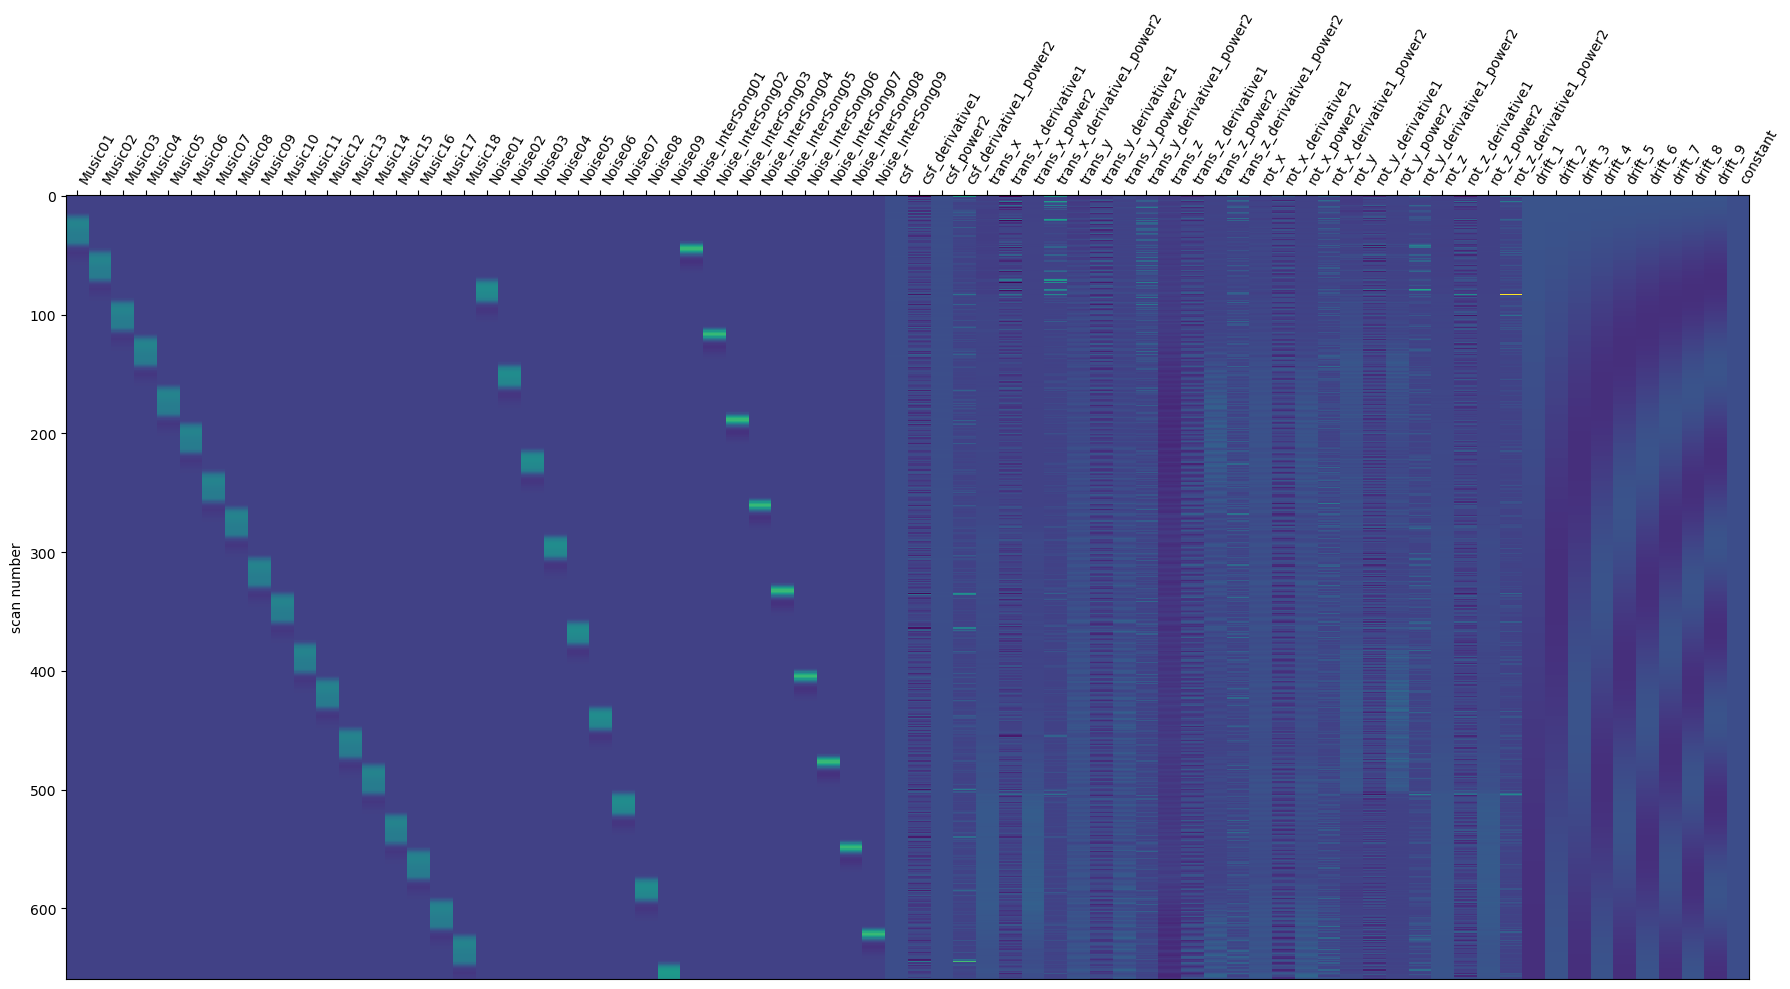

In [24]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(lsa_design)

In [30]:
# GLM
print('Creating GLM')
lsa_glm = FirstLevelModel(t_r=1,
                          standardize=False,
                          signal_scaling=False)

print('Fitting GLM')
lsa_glm.fit(func_file, design_matrices = lsa_design)

# Estimate statistical maps for each condition of interest and trial
z_maps_lsa = []

for contrast in trialwise_conditions:
    z_map = lsa_glm.compute_contrast(contrast, output_type='z_score')

    z_maps_lsa.append(z_map)



Creating GLM
Fitting GLM


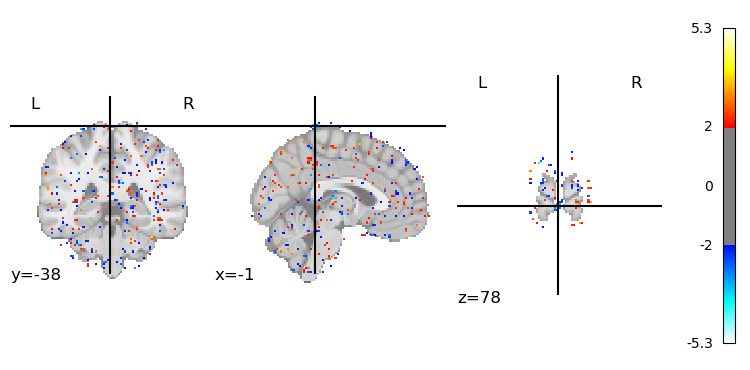

In [37]:
from nilearn import plotting
plotting.plot_stat_map(
    z_maps_lsa[4],
    threshold=2.0,
)

In [ ]:
# 4D image with all the beta maps
img_lsa = concat_imgs(z_maps_lsa)   

# check if image exists - if so delete it
newimage = os.path.join(output_dir, subj + '_ses-01_task-' + task + '_run-' + run + '_musicnoise_confounds_dataset.nii.gz')

if os.path.exists(newimage):
    os.remove(newimage)
    print('Deleted existing image file')

# save concatenated images
img_lsa.to_filename(newimage)

# check if trial_types file exists - if so delete it
newtrialtypes = os.path.join(output_dir, subj + '_ses-01_task-' + task + '_run-' + run + '_musicnoise_confounds_trial_types.txt')

if os.path.exists(newtrialtypes):
    os.remove(newtrialtypes)
    print('Deleted existing trial_types file')

# save trial_types
np.savetxt(newtrialtypes, trialwise_conditions, fmt='%s')

print('Done for subject ' + subj + ' and run ' + run + '\n')